# L'influence du contexte sur le processus d'achat 

Auteurs : Jarod Vanderlynden , Philippe Mathieu, [CRISTAL Lab](http://www.cristal.univ-lille.fr), [SMAC team](https://www.cristal.univ-lille.fr/?rubrique27&eid=17), [Lille University](http://www.univ-lille.fr), Romain Warlop, [fifty-five](https://www.fifty-five.com/fr/)

email : jarod.vanderlynden.etu@univ-lille.fr, philippe.mathieu@univ-lille.fr, romain@fifty-five.com

Création : 11/04/2024

***

## Introduction

Cette feuille Jupyter présente le modèle décrit dans l'article "Stratégies marketing et effets de contexte". Ce modèle permet de simuler des choix faits par des consommateurs. On ne simule pas réellement des achats, mais plutôt à un instant donné, si je présentais un ensemble de produits à cet ensemble d'acheteurs, les acheteurs choisiraient plutôt tel article. 

## Présentation du modèle

Dans ce modèle, nous n'observons qu'une catégorie de produit. Une catégorie de produit est définie comme un ensemble de produits en concurrence directe. Ce modèle simule la présentation d'une catégorie de produits à un ensemble de clients, puis chacun des clients choisit un produit. Les agents sont des abstractions des clients, ils disposent de paramètres internes qu'ils utilisent pour faire leurs choix. Le processus de décision des agents est le même pour chacun d'eux, ils choisissent un produit parmi une liste de produits en concurrence et pour cela, ils font appel à une fonction d'utilité. 


***
## L'objectif du modèle

Notre objectif avec ce modèle est de simuler des achats sur un ensemble de produit en concurrence. Un exemple réel qui pourrait s'appliquer à notre modèle est celui de la téléphonie mobile. [Un exemple](https://www.bouyguestelecom.fr/forfaits-mobiles/sans-engagement) datant du 19/03/2024, dans cet exemple, on voit différentes offres, en concurrence. Typiquement, les clients ont un choix à faire. 

Dans ce type de situations, des recherches ont montré que le contexte (les options disponibles) pouvait influencer le choix des clients. Par exemple, si deux produits A et B sont en concurrence, l'ajout d'un nouveau produit C lui aussi en concurrence va modifier les ventes de A et B. Cependant, selon les caractéristiques de C, les ventes de A ou de B peuvent être augmentées et ce même si C n'est quasiment jamais acheté. Le contexte influence le processus de décision, on parle alors d'effet de contexte. 

### Effet de contexte

En 1982 Joel Huber, John W.  Payne, et Christopher Puto décrivent en premier ce qu'on appellera plus tard effet d'attraction ou effet de leurre. Ils montrent que l'introduction d'un produit avec des caractéristiques spécifiques fait monter les ventes d'un produit déjà existant au détriment des autres. Les ventes de la catégorie de produit n'augmentent pas, c'est bien qu'un des anciens produits devient plus attractif suite à l'introduction d'un nouveau produit, un "leurre". Ce nouveau produit, le leurre doit être plus cher et de moins bonne qualité qu'un des produits disponibles, si on reprend notre exemple de la téléphonie mobile c'est un forfait plus cher avec moins de Go.

__ ___ et ___, proposent plusieurs explications concernant l'existence de l'effet de leurre, parmi ces propositions, on retrouve l'aversion à la perte. L'aversion à la perte est un biais faisant accorder plus d'importance aux pertes qu'aux gains. 

Amos Tversky et Daniel Kahneman en 1991 proposent un modèle d'aversion à la perte, basé sur la notion de référence. Ils se placent dans un contexte bien différent du nôtre cependant, ce sont leurs idées de modélisations que nous utilisons pour développer notre propre modèle. 

En 2007 Tao Zhang, et David Zhang proposent un modèle multi-agent qui reprend l'aversion à la perte et utilise comme référence un produit moyen dont ses caractéristiques sont la moyenne des caractéristiques des produits de la catégorie. Ils montrent que leur modèle est capable de reproduire l'effet de leurre. Cependant, le modèle à des défauts et pourrait aller plus loin dans l'étude des effets de contexte.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Ce paramètre sert à sauvegarder les figures. Si le paramètres est à False, les figures ne sont pas sauvegardées, si ce paramètre est à True les figures seront sauvegardées. 
SAV = False

***

## Le modèle

Dans cette partie, nous introduisons le modèle, ses agents, ses caractéristiques ainsi que son fonctionnement.

### Les produits

Les produits sont des doublets et disposent d'un prix et d'une qualité. Un produit A(80,80) est un produit nommé A avec comme prix 80 et comme qualité 80. Nous utiliserons cette notation dans la suite de cette feuille Jupyter. De plus, le prix et la qualité sont pour le moment abstraites. 

In [2]:
# Pour des raisons d'implémentations, le nom du produit et un numéro sont ajoutés dans la représentation. 
A = [1,"ProduitA",80,80]
B = [2, "ProduitB", 20, 20]

L'ensemble des produits est regroupé en un ensemble dans un DataSet Pandas

In [3]:
products = [A, B]
productSet = pd.DataFrame(products)
productSet.columns =['Num', 'Name', 'Price', 'Quality']
productSet

,Num,Name,Price,Quality
0,1,ProduitA,80,80
1,2,ProduitB,20,20


*** 

### Les agents

De la même manière que les produits, les agents disposent de peu de caractéristiques, ils ont un nom, un revenu et de ce revenu ils ont une sensibilité au prix et à la qualité. 

In [4]:
# Définition de la fonction t permetant de transformer le revenu en sensibilités.
def t(x):
    return x/6000

revenu = 3000
#L'agent, son nom, son revenu, sa sensibilité au prix, sa sensibilité à la qualité.  
Agent0 = ["Agent0", revenu, t(revenu), 1-t(revenu)]
Agent0

['Agent0', 3000, 0.5, 0.5]

***
#### Le revenu des agents

Dans cette section nous tirons 300 revenus qui seront utilisés pour définir le revenu de nos agents. 

(array([ 1.,  7., 15., 50., 52., 68., 55., 29., 19.,  4.]),
 array([1465.07432729, 1752.9419892 , 2040.80965111, 2328.67731302,
        2616.54497493, 2904.41263684, 3192.28029875, 3480.14796066,
        3768.01562257, 4055.88328448, 4343.75094638]),
 <BarContainer object of 10 artists>)

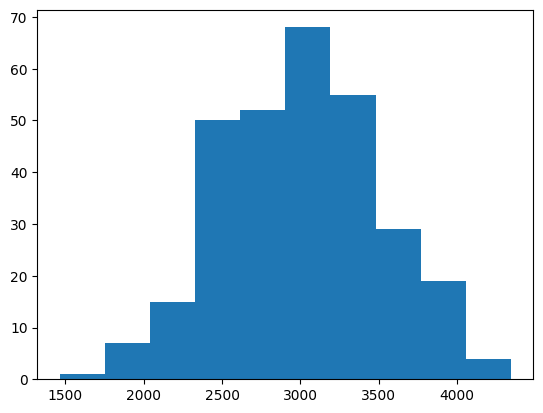

In [5]:
# Définition des bornes supérieures et inférieurs de la distribution du revenu
lower, upper = 1000, 6000
# Définition de la moyenne et de l'écart-type 
mu, sigma = 3000, 500
# Définition de la distribution
X = stats.truncnorm(
    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)

# On tire les revenus de nos futurs agents
revenues = X.rvs(300)
# On affiche un histogramme des revenus afin de s'assurer que tout est bon.
plt.hist(revenues)

***

Nous allons maintenant créer un ensemble de 300 agents, cet ensemble d'agent sera représenté par un DataFrame. 

In [6]:
agentSet = []
for i in range(300):
    revenu = revenues[i]
    agentSet += [["Agent" + str(i), revenu,  t(revenu), 1-t(revenu)]]

agentSet = pd.DataFrame(agentSet)
agentSet.columns =['Name', 'revenu', 'Price_sensibility', 'Quality_sensibility']
agentSet

,Name,revenu,Price_sensibility,Quality_sensibility
0,Agent0,3049.027681,0.508171,0.491829
1,Agent1,3062.361511,0.510394,0.489606
2,Agent2,2150.872749,0.358479,0.641521
3,Agent3,3725.906758,0.620984,0.379016
4,Agent4,3236.194340,0.539366,0.460634
...,...,...,...,...
295,Agent295,3139.310880,0.523218,0.476782
296,Agent296,2217.121883,0.369520,0.630480
297,Agent297,3065.791364,0.510965,0.489035
298,Agent298,2118.538800,0.353090,0.646910


***
## L'environnement

Le code de la Classe SMA qui est la classe représentant l'environnement. Cette classe nécéssite en entrée une base d'agents, des produits, un nombre de pas de temps de simulation ainsi qu'une valeur d'aversion à la perte qui est un paramètres global du modèle.

In [7]:
# Ajouter une méthode Add_Product, et une méthode Add_agent même si cette seconde méthode sera très inneficace. 


class SMA:
    def __init__(self,agent_base,product_base,ticks,loss_aversion):
        self.ticks = ticks
        self.tick = 0
        self.agents = agent_base
        self.agents_history = {}
        self.nb_agents = len(agent_base)
        self.products = product_base
        self.loss_aversion = 1 + loss_aversion
        self.ref_product = product_base.mean(numeric_only=True)
        self.products_history = {}

    def initialize(self):
        self.tick = 0
        for i in range(len(self.agents)):
            self.agents_history[self.agents.iloc[i][0]] = np.zeros(self.ticks)
        for j in range(len(self.products)):
            self.products_history[self.products.iloc[j][0]] = np.zeros(self.ticks)
    
    def run(self):
        for tick in range(self.ticks):
            self.run_once()
            self.tick += 1

    def run_once(self):
        for i in range(len(self.agents)):
            agent_name, revenu, agent_price_sensibility,agent_quality_sensibility = self.agents.iloc[i]
            utilities = np.zeros(len(self.products))
            for j in range(len(self.products)):
                product_num, product_name, product_price, product_quality = self.products.iloc[j]
                utility = self.eval(agent_price_sensibility,agent_quality_sensibility,product_price,product_quality)
                utilities[j] = utility
            bought = self.products.iloc[np.argmax(utilities)][0]
            # print("L'agent", agent_name, "à acheté le produit", bought)
            self.agents_history[agent_name][self.tick]=bought
            self.products_history[bought][self.tick] += 1

    def eval(self,agent_price_sensibility,agent_quality_sensibility,product_price,product_quality):
        ref_price = self.ref_product["Price"]
        ref_quality = self.ref_product["Quality"]
        return (agent_price_sensibility * ((-self.loss_aversion*max(0,  product_price-ref_price)) + max(0,ref_price-product_price)) + 
                agent_quality_sensibility * (max(0,product_quality-ref_quality) - self.loss_aversion * max(0,ref_quality-product_quality)))

***

## La simulation

Dans cette prochaine partie, nous allons réaliser toutes les simulations qui ont été nécessaires à la réalisation de l'article "Stratégies marketing et effets de contexte"

In [8]:
# L'ensemble d'agent qui sera utilisé pour toutes nos simulations.
agentSet

,Name,revenu,Price_sensibility,Quality_sensibility
0,Agent0,3049.027681,0.508171,0.491829
1,Agent1,3062.361511,0.510394,0.489606
2,Agent2,2150.872749,0.358479,0.641521
3,Agent3,3725.906758,0.620984,0.379016
4,Agent4,3236.194340,0.539366,0.460634
...,...,...,...,...
295,Agent295,3139.310880,0.523218,0.476782
296,Agent296,2217.121883,0.369520,0.630480
297,Agent297,3065.791364,0.510965,0.489035
298,Agent298,2118.538800,0.353090,0.646910


In [9]:
# L'ensemble de produit initiaux, A(80,80), B(20,20), dans les simulations on rajoute un produit C qui fera changer le choix des agents.
productSet

,Num,Name,Price,Quality
0,1,ProduitA,80,80
1,2,ProduitB,20,20


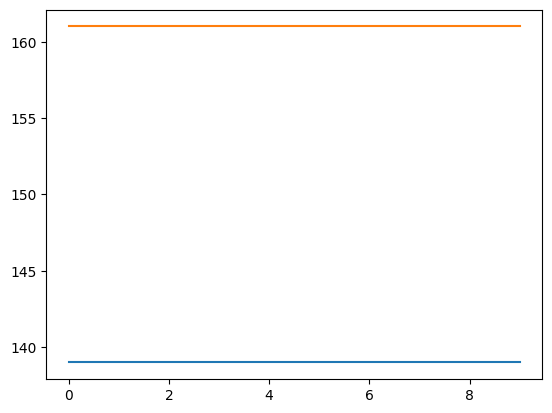

In [10]:
# Initialisation du SMA
monSma = SMA(agentSet,productSet,10,0.5)
monSma.initialize()
# Simulation
monSma.run()
# Récupération des résultats de la simulation
data = pd.DataFrame(monSma.products_history)
# Affichage simple
plt.plot(data)

On observe que le comportement des agents n'est pas modifié au fil du temps. En effet, les agents ne changent pas leurs caractéristiques et les paramètres de l'environnement restent statiques, ainsi les choix que font les agents sont toujours les mêmes. Cela ne pose pas réellement un problème, car en réalité dans ce genre de problème les clients ne choisissent qu'une unique fois quel produit ils achètent. C'est le cas pour les forfaits de téléphone mobile par exemple. Dans des cas d'achats plus répétés, il faudrait prendre en compte certains paramètres comme la loyauté à certaines marques ou à certains produits. 

Enfin le nombre d'agents choisissant le produit A est quasiment le même que ceux choisissant le produit B. C'est à cause de la distribution du revenu que nous avons choisit. Si elle n'était pas symétrique par rapport à la moyenne (3000€) on aurait un déséquilibre sur cette simulation.

***

#### Simulation avec l'introduction de C(40,60)

In [11]:
# Initialisation du SMA
monSma = SMA(agentSet,productSet,10,0.5)
monSma.initialize()
# Simulation
monSma.run()
data = pd.DataFrame(monSma.products_history)
# Ajout de la troisième option, C(40,60)
decoy = pd.DataFrame([[3,"C",40,60]])
decoy.columns =['Num', 'Name', 'Price', 'Quality']
productSet2 = pd.concat([productSet,decoy])
# On recrée un nouveau SMA avec les mêmes agents mais un ensemble de produit différent
monSma = SMA(agentSet,productSet2,10,0.5)
monSma.initialize()
# Simulation
monSma.run()
data2 = pd.DataFrame(monSma.products_history)

# On récupère et met en forme les données
res0 = pd.concat([data[1],data2[1]],ignore_index=True)
res1 = pd.concat([data[2],data2[2]],ignore_index=True)
res2 = np.array([*np.zeros(10), *data2[3]])

On définit une fonction d'affichage uniquement pour cette section

In [12]:
def myPlot(res0,res1,res2):
    ax = plt.axes()
    ax.plot(res0,'-',label='Option_A')
    ax.plot(res1,':',label='Option_B')
    ax.plot(np.arange(0, len(res0), 1, dtype=int), res2, "-.",label='Option_C')
    #ax.axvline(x = 19, color = 'r', label = 'Introducing decoy pack')
    ax.legend()
    plt.xlabel("Ticks")
    plt.ylabel("Number of favorites")

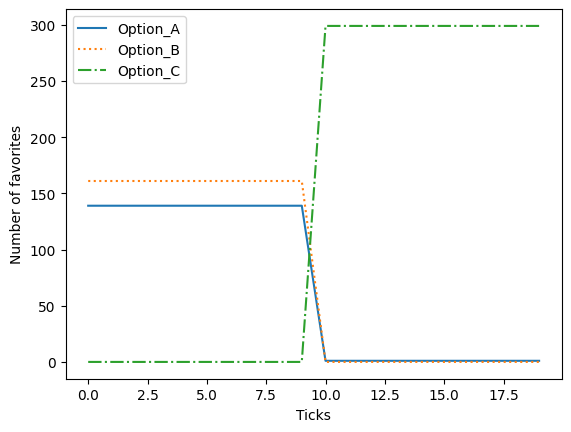

In [13]:
myPlot(res0,res1,res2)

Sur cette figure, on observe que l'option C cannibalise les ventes des autres produits. L'option C ayant un meilleur rapport qualité/prix que les autres produits, elle bénéficie d'une forte attraction vis-à-vis des produits A et B. Par la suite lorsqu'on indiquera que les caractéristiques d'un produit sont meilleurs que celle d'un autre, c'est pour indiquer un meilleur rapport qualité/prix.

On réalise une fonction pour la suite afin de gagner en lisibilité.

In [14]:
def simDecoy(Cprice, Cquality):
    monSma = SMA(agentSet,productSet,10,0.5)
    monSma.initialize()
    # Simulation
    monSma.run()
    data = pd.DataFrame(monSma.products_history)
    # Ajout de la troisième option, C(40,60)
    decoy = pd.DataFrame([[3,"C",Cprice,Cquality]])
    decoy.columns =['Num', 'Name', 'Price', 'Quality']
    productSet2 = pd.concat([productSet,decoy])
    # On recrée un nouveau SMA avec les mêmes agents mais un ensemble de produit différent
    monSma = SMA(agentSet,productSet2,10,0.5)
    monSma.initialize()
    # Simulation
    monSma.run()
    data2 = pd.DataFrame(monSma.products_history)
    
    # On récupère et met en forme les données
    res0 = pd.concat([data[1],data2[1]],ignore_index=True)
    res1 = pd.concat([data[2],data2[2]],ignore_index=True)
    res2 = np.array([*np.zeros(10), *data2[3]])
    return res0, res1, res2

***

#### Simulation avec l'introduction de C(25,35)

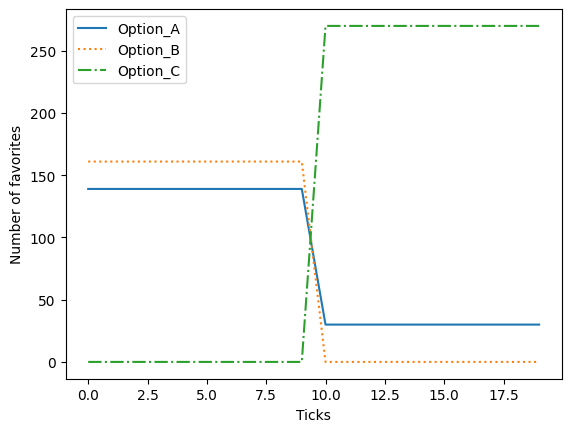

In [15]:
myPlot(*simDecoy(25,35))

On observe sur cette figure que l'option C cannibalise asymétriquement les ventes de A et B. En effet, les caractéristiques de C sont toujours meilleures que les caractéristiques de A et B. DE plus, les caractéristiques de C sont plus proches de B, B est plus impacté par la baisse de ses ventes.  

***

#### Simulation avec l'introduction de C(80,95)

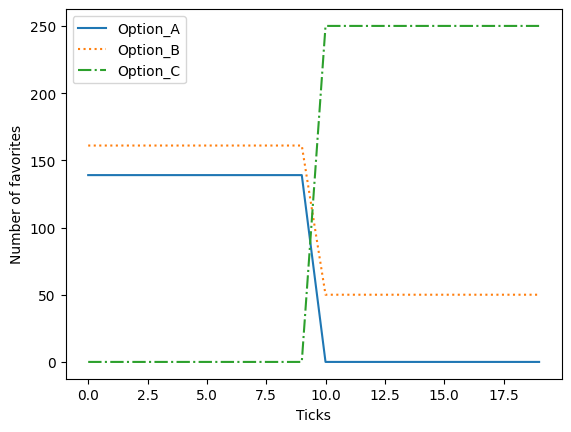

In [16]:
myPlot(*simDecoy(80,95))

On observe la même chose que précédemment, les caractéristiques de C sont meilleurs alors cette option cannibalise les ventes de A et B. Cependant comme les caractéristiques de C sont plus proches de A, A voit ses ventes diminuer plus fortement. 

***

#### Simulation avec l'introduction de C(30,10)

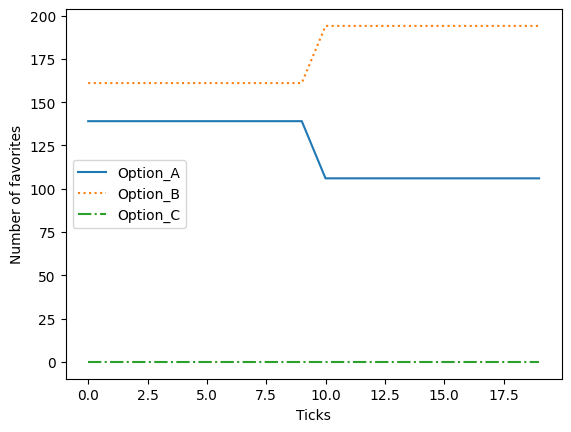

In [17]:
myPlot(*simDecoy(30,10))

Après avoir montré qu'une nouvelle option peut cannibaliser les ventes des produits déjà présents dans la catégorie, on montre ici que cette nouvelle option peut augmenter les ventes des produits existants. Dans cette simulation, les caractéristiques de B dominent celles de C ($B \succ C$) tandis que les caractéristiques de A ne dominent que partiellement celles de C ($A \succeq C$). On observe l'effet de leurre, les ventes de B s'améliorent. Les ventes de A diminuent et le produit C n'est jamais acheté, car sous optimal. Cela vient de fait que nos simulations sont déterministes et les agents choisissent toujours le produit avec la meilleure utilité. 

***

#### Simulation avec l'introduction de C(90,70)

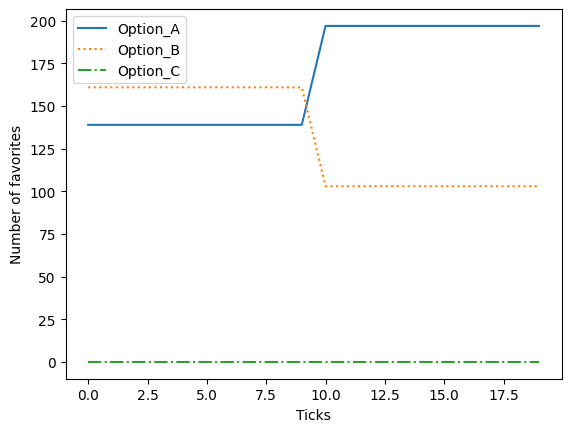

In [18]:
myPlot(*simDecoy(90,70))

Cette fois ($A \succ C$) et ($B \succeq C$), le leurre (l'option C) fait agmenter les ventes du poduit A

***

#### Simulation avec l'introduction de C(100,80)

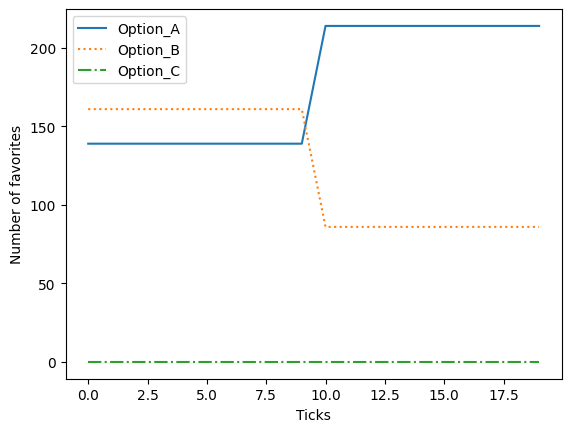

In [19]:
myPlot(*simDecoy(100,80))

On observe que sous certaines caractéristiques du leurre, les ventes de A augmentent plus significativement. 

***

#### Simulation avec l'introduction de C(15,0)

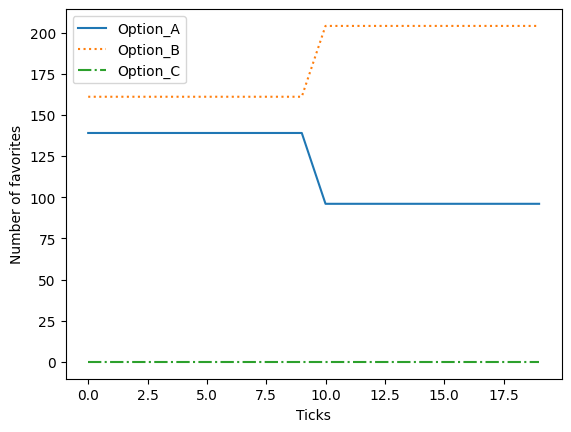

In [20]:
myPlot(*simDecoy(15,0))

Et cette augmentation est la même pour l'option B. Cette symétrie s'explique, car les caractéristiques de notre population d'agent sont symétriques par rapport à la moyenne (loi normale). 

***

#### Simulation avec l'introduction de C(55,45)

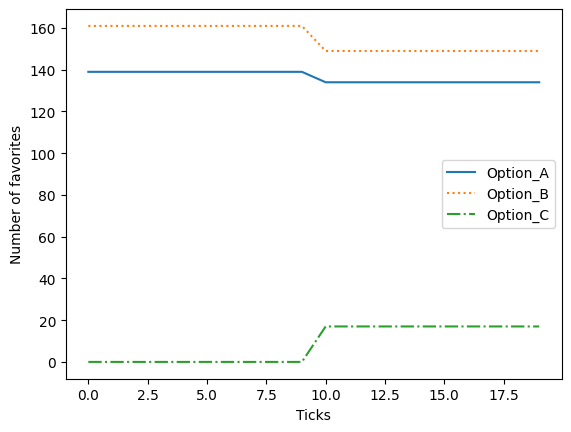

In [21]:
myPlot(*simDecoy(55,45))

Avec cette simulation, nous montrons que notre modèle est capable de reproduire l'effet de compromis. L'effet de compromis indique que les options avec des caractéristiques "moyenne", au milieu d'autres options extrêmes, paraissent plus intéressantes. 

L'option C dispose de caractéristiques moins intéressantes que A et B cependant elle bénéficie quand même de ventes, car cette option a des caractéristiques se situant entre A et B. D'ailleurs cet effet entre aussi en compte lors de nos premières simulation. 

***

#### Simulation avec l'introduction de C(1,1)

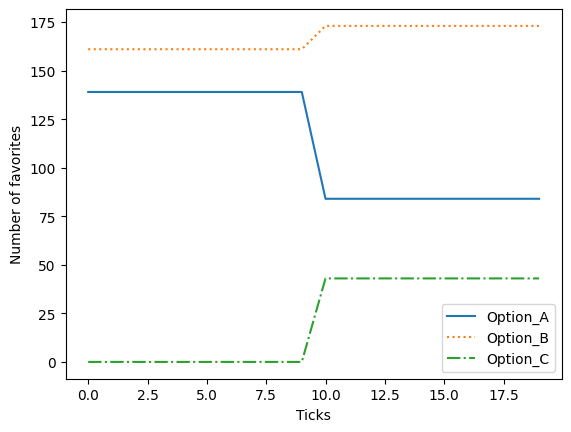

In [22]:
myPlot(*simDecoy(1,1))

Sur cette simulation, l'option C agit comme une offre extrême, moins cher et de moins bonne qualité que B. De ce fait; l'option C produit un effet de compromis profitant à l'option B. On voit que les ventes de B augmentent. 

***

#### Simulation avec l'introduction de C(100,100)

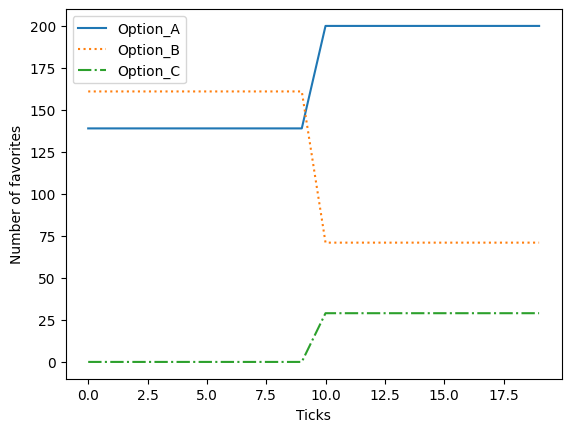

In [23]:
myPlot(*simDecoy(100,100))

Sur cette simulation, l'option C agit comme une offre extrême, plus cher et de meilleure bonne qualité que A. De ce fait, l'option C produit un effet de compromis profitant à l'option A. On voit que les ventes de A augmentent. 

*** 

## Reproduction des matrices

/!\ Attention, cette partie est longue à reproduire étant donné qu'il y a un grand nombre de simulations. 

In [24]:
# 2 tour de boucle de simulation suffisent. Rien ne justifie pour le moment d'en faire plus.
mat_size = 100
resA = np.zeros((mat_size,mat_size))
resB = np.zeros((mat_size,mat_size))
resC = np.zeros((mat_size,mat_size))
for i in range(mat_size):
    print(i, end=", ")
    for j in range(mat_size):
        monSma = SMA(agentSet,productSet,1,1)
        monSma.initialize()
        monSma.run()
        data = pd.DataFrame(monSma.products_history)
        decoy = pd.DataFrame([[3, 'C', i, j]])
        decoy.columns =['Num', 'Name', 'Price', 'Quality']
        productSet2 = pd.concat([productSet,decoy])
        monSma = SMA(agentSet,productSet2,1,1)
        monSma.initialize()
        monSma.run()
        data2 = pd.DataFrame(monSma.products_history)
        res0 = pd.concat([data[1],data2[1]],ignore_index=True)
        res1 = pd.concat([data[2],data2[2]],ignore_index=True)
        res2 = data2[3]
        resA[i][j] = (res0.iloc[1]/res0.iloc[0]-1)*100
        resB[i][j] = (res1.iloc[1]/res1.iloc[0]-1)*100
        resC[i][j] = res2.iloc[0]

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 

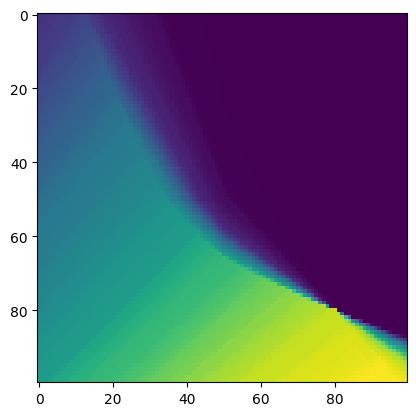

In [25]:
plt.imshow(resA)

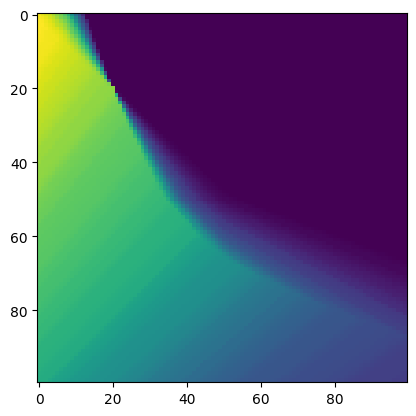

In [26]:
plt.imshow(resB)

In [27]:
pd.DataFrame(resA).to_csv("Reduced_Model_DecoyEffectMatrix_A_random_agents.csv")
pd.DataFrame(resB).to_csv("Reduced_Model_DecoyEffectMatrix_B_random_agents.csv")
pd.DataFrame(resC).to_csv("Reduced_Model_DecoyEffectMatrix_C_random_agents.csv")

***

## Reproduction de l'exemple réel.



In [30]:
A = [1,"OffreA",6.99,2]
B = [2, "OffreB", 9.99, 2]
C = [3, "OffreC", 9.99, 10]
D = [4, "OffreD", 12.99, 10]
E = [5, "OffreE",10.99, 13]
F = [6, "OffreF",17.99, 20]
products = [A, B, C, D, E, F]
productSet = pd.DataFrame(products)
productSet.columns =['Num', 'Name', 'Price', 'Quality']

monSma = SMA(agentSet,productSet,10,0.5)
monSma.initialize()
# Simulation
monSma.run()
data = pd.DataFrame(monSma.products_history)# Ajout de la troisième option, C(40,60)
data
# decoy = pd.DataFrame([[3,"C",Cprice,Cquality]])
# decoy.columns =['Num', 'Name', 'Price', 'Quality']
# productSet2 = pd.concat([productSet,decoy])
# # On recrée un nouveau SMA avec les mêmes agents mais un ensemble de produit différent
# monSma = SMA(agentSet,productSet2,10,0.5)
# monSma.initialize()
# # Simulation
# monSma.run()
# data2 = pd.DataFrame(monSma.products_history)
    
# On récupère et met en forme les données
# res0 = pd.concat([data[1],data2[1]],ignore_index=True)
# res1 = pd.concat([data[2],data2[2]],ignore_index=True)
# res2 = np.array([*np.zeros(10), *data2[3]])
# return res0, res1, res2


# ax = plt.axes()
# ax.plot(res0,'-',label='Option_A')
# ax.plot(res1,':',label='Option_B')
# ax.plot(np.arange(0, len(res0), 1, dtype=int), res2, "-.",label='Option_C')
# #ax.axvline(x = 19, color = 'r', label = 'Introducing decoy pack')
# ax.legend()
# plt.xlabel("Ticks")
# plt.ylabel("Number of favorites")

,1,2,3,4,5,6
0,0.0,0.0,0.0,0.0,269.0,31.0
1,0.0,0.0,0.0,0.0,269.0,31.0
2,0.0,0.0,0.0,0.0,269.0,31.0
3,0.0,0.0,0.0,0.0,269.0,31.0
4,0.0,0.0,0.0,0.0,269.0,31.0
5,0.0,0.0,0.0,0.0,269.0,31.0
6,0.0,0.0,0.0,0.0,269.0,31.0
7,0.0,0.0,0.0,0.0,269.0,31.0
8,0.0,0.0,0.0,0.0,269.0,31.0
9,0.0,0.0,0.0,0.0,269.0,31.0
